In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime
import numpy as np
import io_utils

from matplotlib import pyplot as plt
from IPython import display

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.8.0


In [2]:
if tf.test.gpu_device_name(): 
    print("Default GPU: {}".format(tf.test.gpu_device_name()))
else:
    print("Not using a GPU - it will take long!!")

Default GPU: /device:GPU:0


In [3]:
from configuration import *
print("DATASET_SIZE", DATASET_SIZE)
print("TRAIN_SIZE", TRAIN_SIZE)
print("TEST_SIZE", TEST_SIZE)

np.random.seed(SEED)
tf.random.set_seed(SEED)

DATASET_SIZE 294
TRAIN_SIZE 250
TEST_SIZE 44


In [4]:
from dataset_utils import create_paired_s2s_image_loader as create_image_loader

train_dataset = tf.data.Dataset.range(TRAIN_SIZE).shuffle(TRAIN_SIZE)
test_dataset = tf.data.Dataset.range(TEST_SIZE).shuffle(TEST_SIZE)

f2r_train_dataset = train_dataset.map(create_image_loader(2, 3, TRAIN_SIZES, "train", True), num_parallel_calls=tf.data.AUTOTUNE)
f2r_train_dataset = f2r_train_dataset.batch(BATCH_SIZE)
f2r_test_dataset = test_dataset.map(create_image_loader(2, 3, TEST_SIZES, "test", False))
f2r_test_dataset = f2r_test_dataset.batch(BATCH_SIZE)

f2b_train_dataset = train_dataset.map(create_image_loader(2, 0, TRAIN_SIZES, "train", True), num_parallel_calls=tf.data.AUTOTUNE)
f2b_train_dataset = f2b_train_dataset.batch(BATCH_SIZE)
f2b_test_dataset = test_dataset.map(create_image_loader(2, 0, TEST_SIZES, "test", False))
f2b_test_dataset = f2b_test_dataset.batch(BATCH_SIZE)

f2l_train_dataset = train_dataset.map(create_image_loader(2, 1, TRAIN_SIZES, "train", True), num_parallel_calls=tf.data.AUTOTUNE)
f2l_train_dataset = f2l_train_dataset.batch(BATCH_SIZE)
f2l_test_dataset = test_dataset.map(create_image_loader(2, 1, TEST_SIZES, "test", False))
f2l_test_dataset = f2l_test_dataset.batch(BATCH_SIZE)

In [5]:
# from pix2pix_model import Unet2Generator
# gen = Unet2Generator()
# gen.summary()

In [6]:
from pix2pix_model import Pix2PixModel#, Pix2PixWassersteinModel#, Pix2PixFFTModel

# f2r = Pix2PixFFTModel(f2r_train_dataset, f2r_test_dataset, "front2right", "pix2pix-rpgmakerxp-fftsquare1000", LAMBDA_FFT=1000)
model = Pix2PixModel.build(f2r_train_dataset, f2r_test_dataset, "front2right", "pix2pix-playground-gansinglevsmultiple2", "patch", "unet", "gan", discriminator_steps=2)

In [7]:
STEPS = 200
UPDATE_STEPS = 100
SHOULD_SAVE_RESULTS = False
SHOULD_GENERATE_ALL_IMAGES_FROM_TEST = False

# print("Starting training...")
# model.fit(STEPS, UPDATE_STEPS, callbacks=[])#"show_patches"])#, "fid"])

Time since start: 01m:19s
Estimated time to finish: 00m:00s
Last 100 steps took: 30.17s



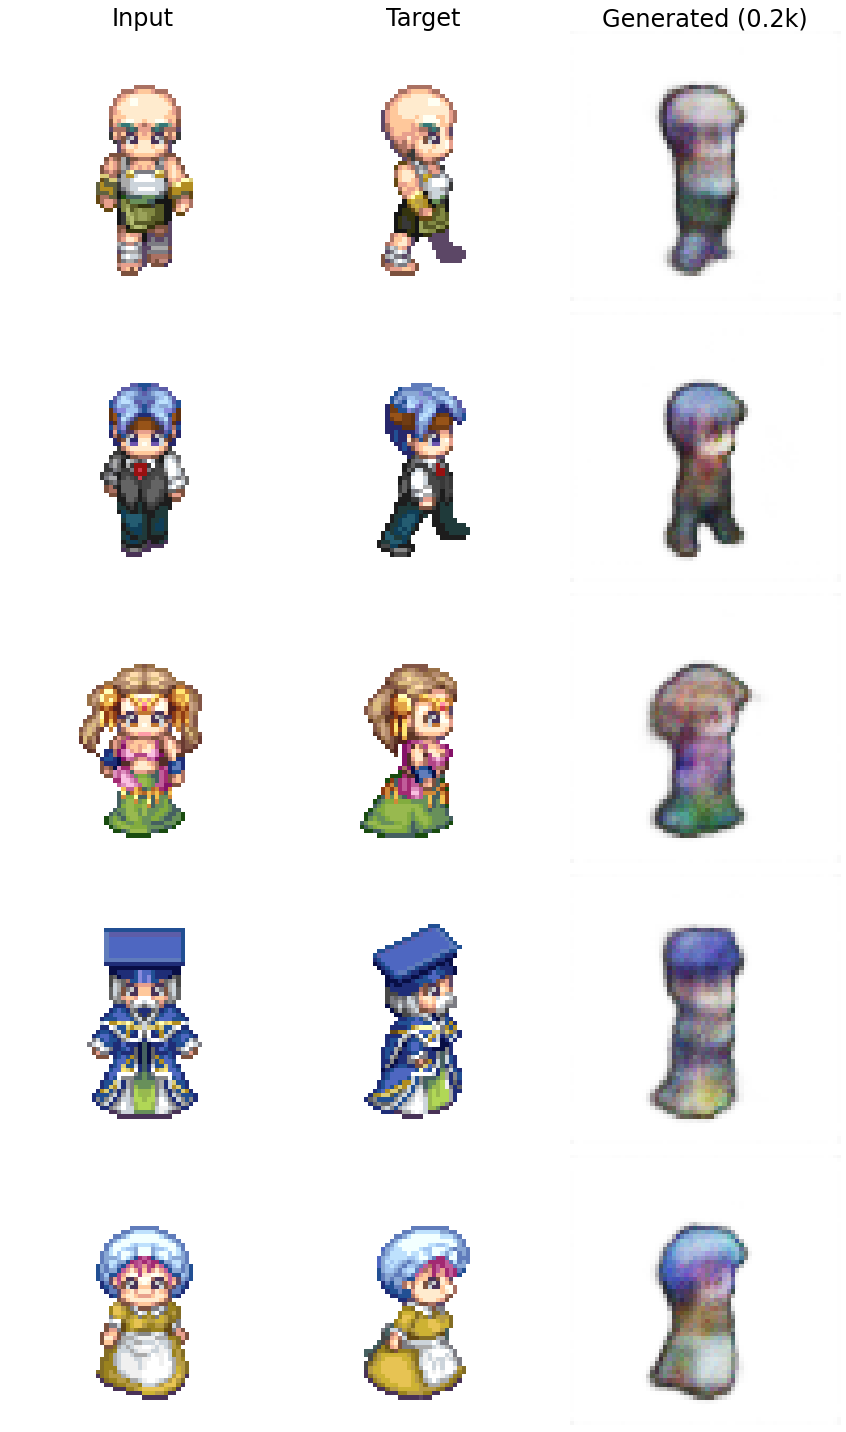

Calculating Fréchet Inception Distance at 0.2k with 44 test examples... FID: 35.62656
Showing discriminator patches


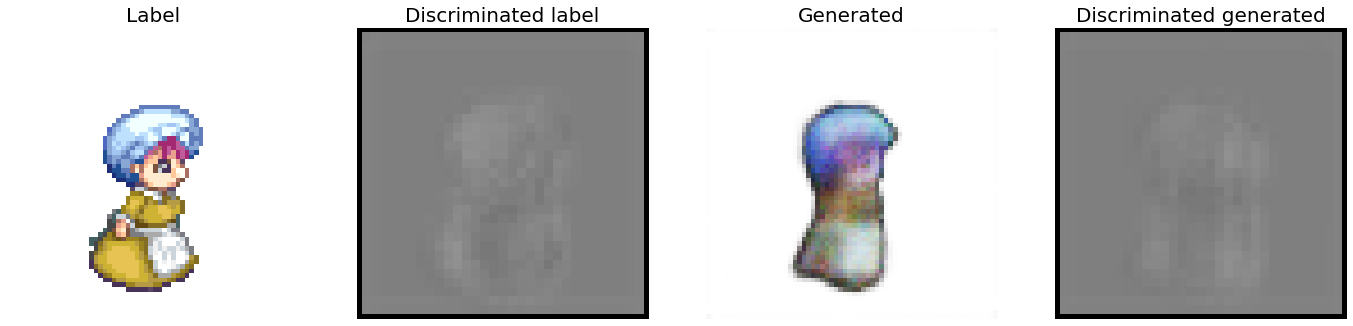

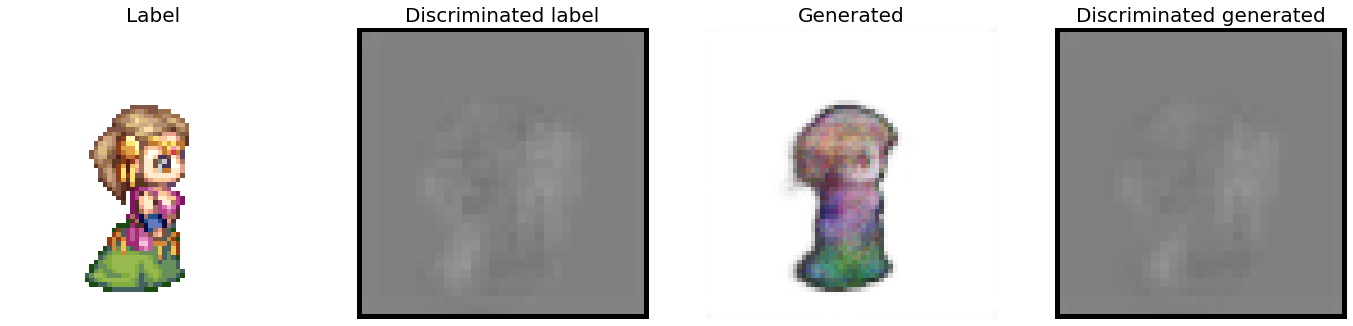

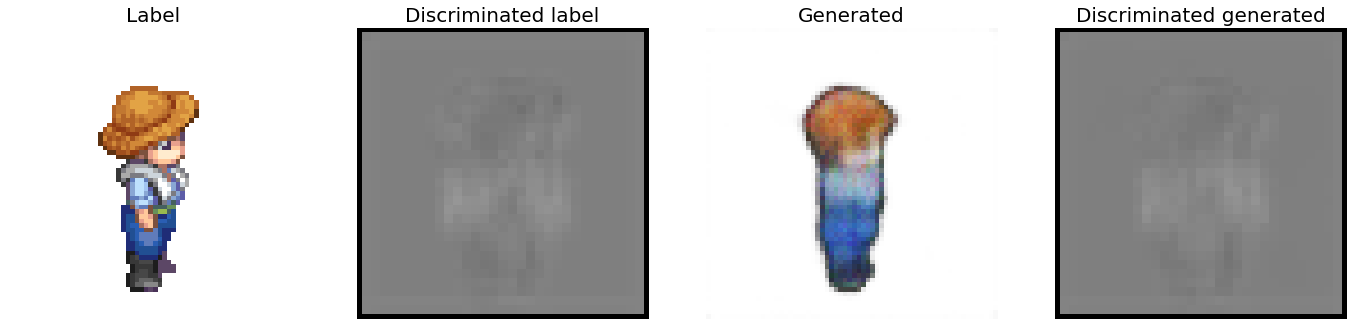

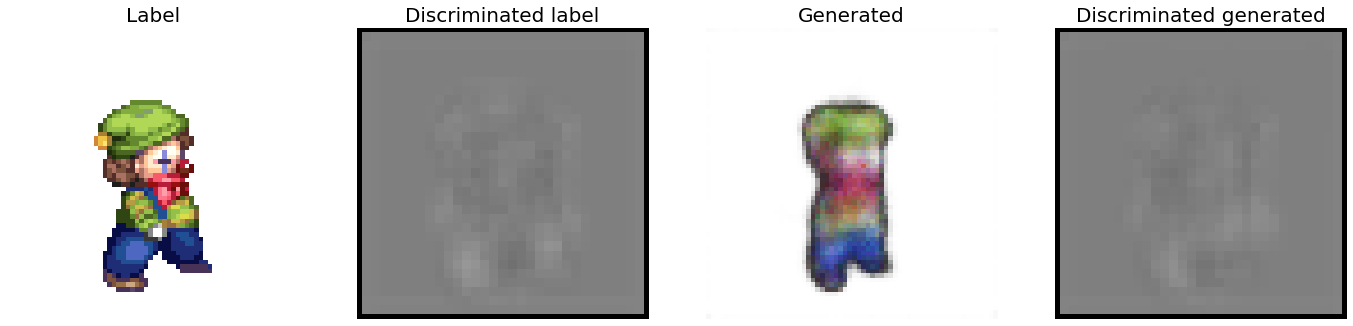

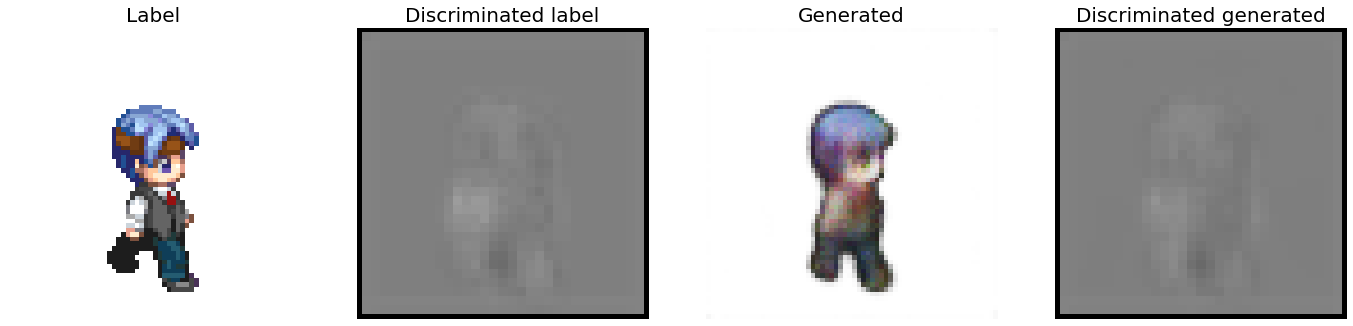

Step: 0.2k


In [8]:
# print("More training...")
# model.save_generator()
# model = Pix2PixModel(f2r_train_dataset, f2r_test_dataset, "front2right", "pix2pix-rpgmakerxp-unetafterunet-unet", "unet", "unet", LAMBDA=100.)
# model.generator = tf.keras.models.load_model(os.sep.join(["models", "py", "generator", "pix2pix-rpgmakerxp-unet-unet", "front2right"]))
model.fit(STEPS, UPDATE_STEPS, callbacks=["fid", "show_patches"])


In [9]:
if SHOULD_GENERATE_ALL_IMAGES_FROM_TEST:
    # f2r.load_generator()
    model.generate_images_from_dataset()

In [10]:
if SHOULD_SAVE_RESULTS:
    model.save_generator()
    model.save_discriminator()

In [11]:
# print("Showing discriminator output from TRAIn set...")
# model.show_discriminated_images("train")
# print("Showing discriminator output from TEST set...")
# model.show_discriminated_images("test")

In [12]:
# model.load_generator()
# model.generate_images_from_dataset(dataset_name="train", num_images=3)
#
# print("Discriminated images from test")
# model.load_discriminator()
# model.show_discriminated_images("train")